In [1]:
# ============================================================
# Notebook setup: run this before everything
# ============================================================

%load_ext autoreload
%autoreload 2

# Control figure size
interactive_figures = False
if interactive_figures:
    # Normal behavior
    %matplotlib widget
    figsize=(9, 3)
else:
    # PDF export behavior
    figsize=(14, 4)

from sklearn.neighbors import KernelDensity
from util import util
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

data_folder = '../data/nab'
file_name = 'realKnownCause/nyc_taxi.csv'
data, labels, windows = util.load_series(file_name, data_folder)

# KDE for Our Anomaly Detection Case Study

## A Few Tweaks

**We will work with _log probabilities_**

* This is what sklearn does by default
* ...And simplifies some operations
* I.e. products become sums

**Additionally, we will work with _negated_ (log) probabilities**

* They can be interpreted as _alarm signals_
* ...Which is the customary approach in anomaly detection

**Overall, our anomaly detection condition becomes:**

$$
-\log f(x, \theta) \geq \varepsilon
$$

...Which is equivalent to the previous formulation



## Training and Testing

**We will split our data in two segments**

A _training set_:

* This will include only data about the _normal_ behavior
* Ideally, there should be no anomalies here (we do not want to learn them!)
* We will use it to fit a KDE model

A _test set_:

* To assess how well the approach can generalize

**If the training set contains some anomalies**

* Things may still be fine, as long as they are very _infrequent_
* ...Since we will still learn that they have low probability


## Training and Testing

**In time series data sets are often split chronologically:**

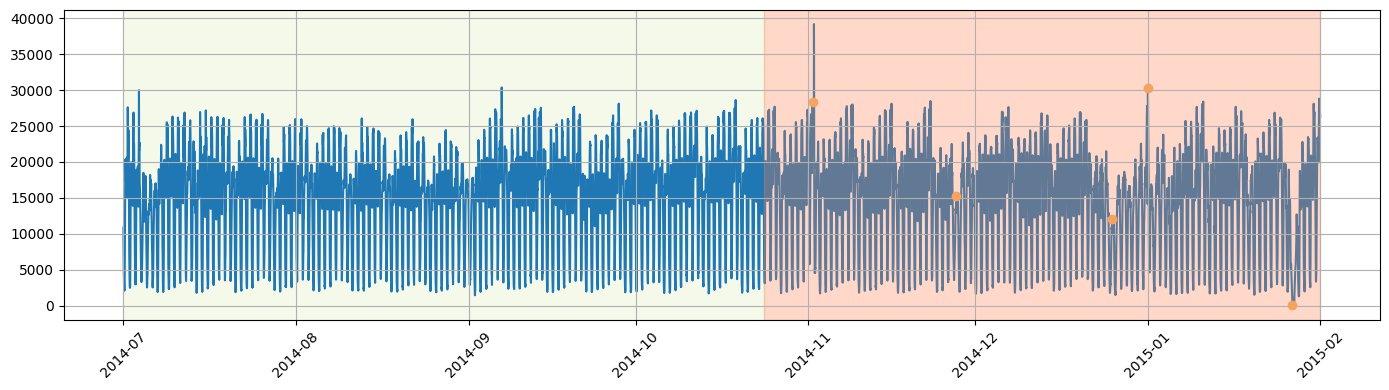

In [2]:
train_end = pd.to_datetime('2014-10-24 00:00:00')
util.plot_series(data, labels, test_start=train_end, figsize=figsize)

* Green: training set, orange: test set

## Fitting the Estimator

**Now, we can separate the training set**

...And estimate the bandwidth by using the rule of thumb:

In [3]:
data_tr = data[data.index < train_end]
q1 = data_tr['value'].quantile(0.25)
q3 = data_tr['value'].quantile(0.75)
sigma = data_tr['value'].std()
m =  len(data_tr)
h = 0.9 * min(sigma, (q3-q1)/ 1.34) * m**(-0.2)
print(f'The estimated bandwidth is {h:.3f}')

The estimated bandwidth is 1056.061


**Then we fit a univariate KDE estimator (using scikit-learn)**

In [4]:
kde = KernelDensity(kernel='gaussian', bandwidth=h)
kde.fit(data_tr.values);

## Fitting the Estimator

**Let's have a look at the estimate distribution:**

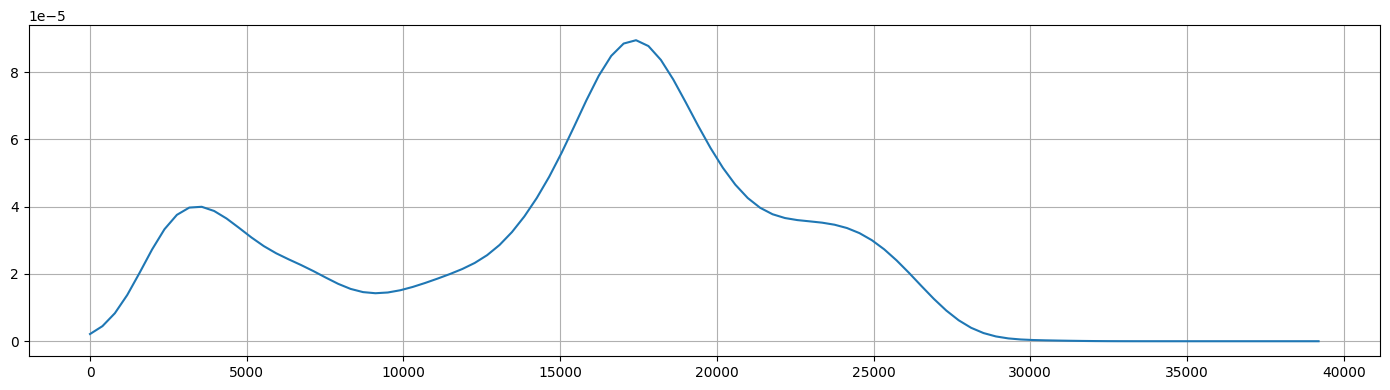

In [6]:
vmax = data['value'].max()
xr = np.linspace(0, vmax, 100)
util.plot_density_estimator_1D(kde, xr, figsize=figsize)

## Alarm Signal

**We can now obtain (and plot) our _alarm signal_:**

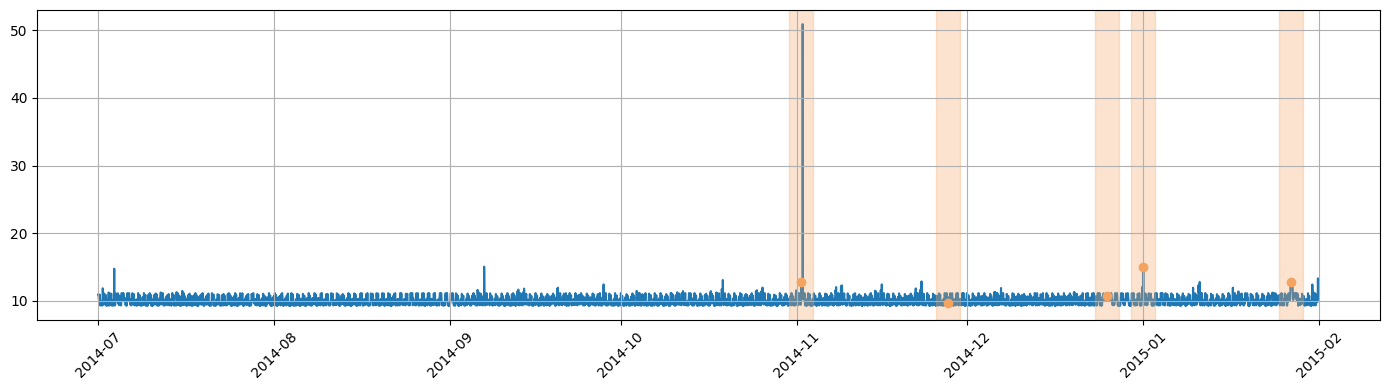

In [7]:
ldens = kde.score_samples(data.values) # Obtain log probabilities
signal = pd.Series(index=data.index, data=-ldens) # Build series with neg. prob.
util.plot_series(signal, labels=labels, windows=windows, figsize=figsize) # Plot

* Notice how the the process (inference) is noticeably slower than training
* Can you tell why this was the case?

## Detecting Anomalies

**Let us pick a threshold (at random, for now) and try to detect some anomalies:**

In [8]:
thr = 12
pred = pd.Series(signal.index[signal >= thr])
print(pred.head(), f'#anomalies: {len(pred)}')

0   2014-07-03 19:00:00
1   2014-09-06 22:30:00
2   2014-09-06 23:00:00
3   2014-09-06 23:30:00
4   2014-09-27 23:00:00
Name: timestamp, dtype: datetime64[ns] #anomalies: 49


* We just apply the filter `signal >= thr` to the signal index
* This yields a number of (predicted) anomalous timestamps
* Our module contains a function to perform this step:

```python
def get_pred(signal, thr)
```

## Detecting Anomalies

**Let us plot our predictions on the series:**

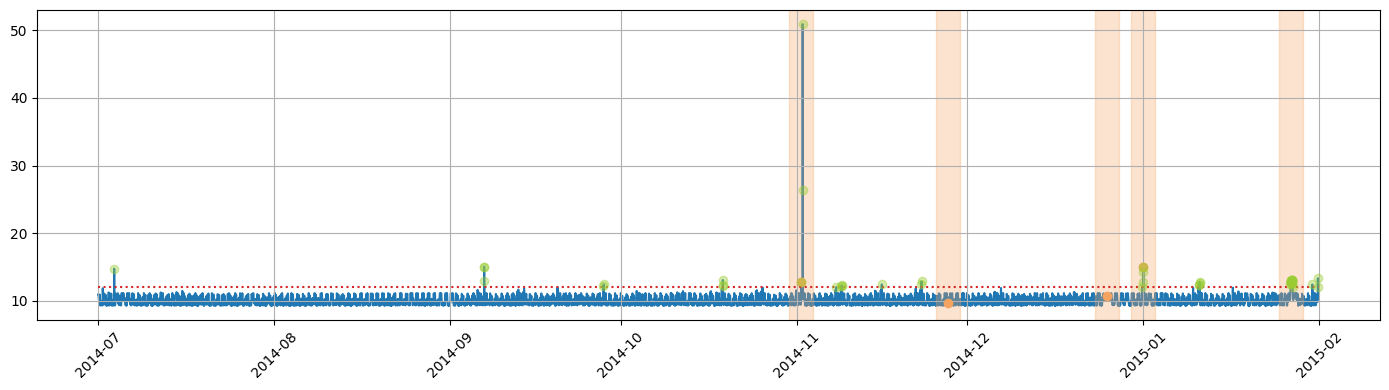

In [9]:
util.plot_series(signal, labels=labels, windows=windows, predictions=pred, threshold=thr, figsize=figsize)

* Not very good, but the threshold _is_ random
* There are a many false positives, which are _very common_ in anomaly detection

# Metrics for Anomaly Detection

<div class=big>How do we evaluate the quality of our system?</div>

## Metrics for Anomaly Detection

**Evaluating the quality of an Anomaly Detection system can be tricky**

* Usually, we do not need to match the anomalies exactly
* Sometimes we wish to anticipate anomalies
* ...But sometimes we just want to detect them in past data

There is no "catch-all" metric, like accuracy in classification

**It is much better to devise a _cost model_**

* We evaluate the cost and benefits of our predictions:
* By doing this, we focus on _the value for our customer_

> **This is important _for all industrial problems!_**


## A Simple Cost Model

**We will use a simple cost model**

Remember that our goals are:

* Analyzing anomalies
* Anticipating anomalies


First, we define:

* _True Positives_ as windows for which we detect at least one anomaly
* _False Positives_ as detected anomalies that do not fall in any window
* _False negatives_ as anomalies that go undetected
* _Advance_ as the time between an anomaly and when first we detect it

## A Simple Cost Model

**They can be computed using a function in our module:**

```python
def get_metrics(pred, labels, windows)
```

In [12]:
tp, fp, fn, adv = util.get_metrics(pred, labels, windows)
print('True Positives', tp.head(), f'#true positives: {len(tp)}')

True Positives 0   2014-11-01 19:00:00
1   2015-01-01 01:00:00
2   2015-01-27 00:00:00
dtype: datetime64[ns] #true positives: 3


In [13]:
print('Advance', adv.head(), 'For each true positive')

Advance 0   0 days 00:00:00
1   0 days 04:00:00
2   0 days 01:00:00
dtype: timedelta64[ns] For each true positive


## A Simple Cost Model

**They can be computed using a function in our module:**

```python
def get_metrics(pred, labels, windows)
```

In [14]:
print('False Positives', fp.head(), f'#false positives: {len(fp)}')

False Positives 0   2014-07-03 19:00:00
1   2014-09-06 22:30:00
2   2014-09-06 23:00:00
3   2014-09-06 23:30:00
4   2014-09-27 23:00:00
dtype: datetime64[ns] #false positives: 23


In [15]:
print('False Negatives', fn.head(), f'#false negatives: {len(fn)}')

False Negatives 0   2014-11-27 15:30:00
1   2014-12-25 15:00:00
dtype: datetime64[ns] #false negatives: 2


## A Simple Cost Model

**Then we introduce:**

* A cost $c_{alarm}$ for loosing time in analyzing false positives
* A cost $c_{missed}$ for missing an anomaly
* A cost $c_{late}$ for a late detection (partial loss of value)

Our cost model (simple, but serviceable) is then given by:

In [16]:
c_alrm = 1 # Cost of investigating a false alarm
c_missed = 10 # Cost of missing an anomaly
c_late = 5 # Cost for late detection

# A simple cost model
cost = c_alrm * len(fp) + \
       c_missed * len(fn) + \
       c_late * (len([a for a in adv if a.total_seconds() <= 0]))
print(f'The cost with the current predictions is: {cost}')

The cost with the current predictions is: 48


<div class=big>Of course, in a real problem the cost model should be <em>discussed with the stakeholders</em></div>

# Threshold Choice

## Refactoring the Cost Model

**We will use this cost model for _choosing our threshold_**

With this aim, we encapsulate the formula in a Python class in our module:

```python
class ADSimpleCostModel:
    def __init__(self, c_alrm, c_missed, c_late):
        # Store cost parameters
        ...

    def cost(self, signal, labels, windows, thr):
        # Compute the cost
        ...
```

## Refactoring the Cost Model

**We can now evaluate our cost by:**

* Instantiating the class with our values for $c_{alarm}, c_{missed}, c_{late}$
* Calling the `cost` function with different threshold values

In [17]:
cmodel = util.ADSimpleCostModel(c_alrm, c_missed, c_late)
cost = cmodel.cost(signal, labels, windows, thr)
print(f'The cost with the current predictions is: {cost}')

The cost with the current predictions is: 48


**The process is rather efficient:**

* When we change the threshold
* ...We _do not need to rebuild_ the alarm signal

So, no need to repeat either training or inference 

## Effect of the Threshold

**We can now look at the effect of changing the threshold:**

First, we'll do this for an _idealized problem_ (i.e. over all the data)

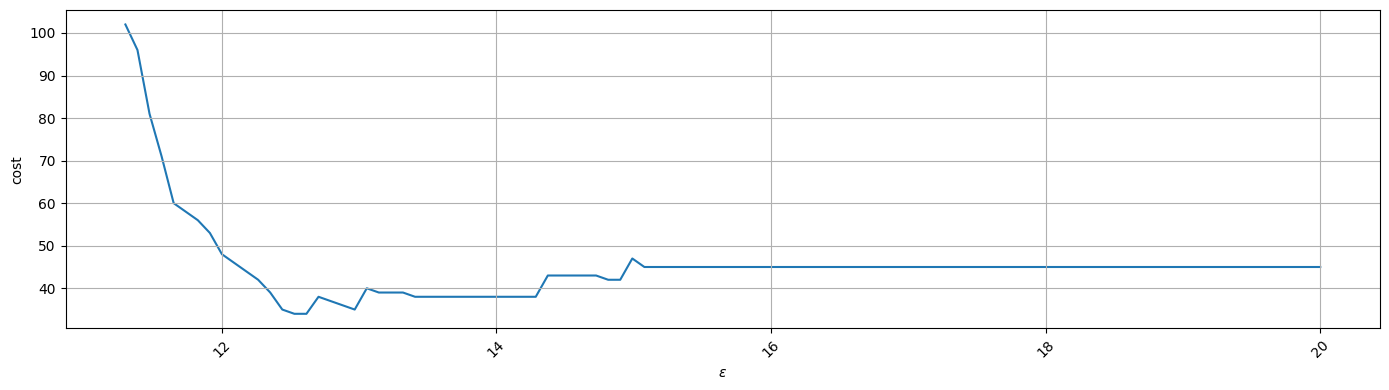

In [20]:
cmodel = util.ADSimpleCostModel(c_alrm, c_missed, c_late)
thr_range = np.linspace(11.3, 20, 100)
cost_range = pd.Series(index=thr_range, data=[cmodel.cost(signal, labels, windows, thr) for thr in thr_range])
util.plot_series(cost_range, figsize=figsize, xlabel=r'$\varepsilon$', ylabel='cost')

## Choosing the Threshold

**Ideally, we wish to choose _the best threshold_**

However, we have two problems:

* We cannot really use all the data
* ...we need to keep some away to test generalization
* The threshold-to-cost function is non-smooth and non-differentiable

**Luckily, both are easy to address**

We can:

* Define a _validation set_ to use when optimizing the threshold
* Use a simple _line search approach_, since $\varepsilon$ is a scalar

## Define a Validation Set

**First, we define our validation set:**

* It should contain some anomalies
* ...But some should be left our (for testing)


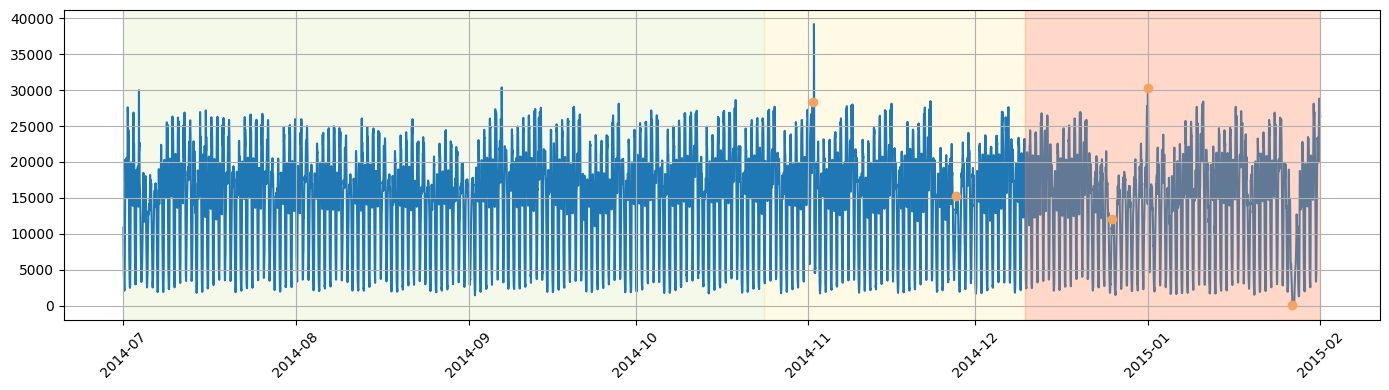

In [21]:
val_end = pd.to_datetime('2014-12-10 00:00:00')
util.plot_series(data, labels, val_start=train_end, test_start=val_end, figsize=figsize)

## Optimize the Threshold

**We will use a line sampling approach:**

We build the validaton set and define a range of "sampled" thresholds:

In [22]:
signal_opt = signal[signal.index < val_end]
labels_opt = labels[labels < val_end]
windows_opt = windows[windows['end'] < val_end]

**Then, we use a function from our module to pick the best one:**

```python
def opt_thr(signal, labels, windows, cmodel, thr_range):
    costs = # compute costs as before
    best_idx = np.argmin(costs)
    return thr_range[best_idx], costs[best_idx]
```

## Validation Set?

**Did you notice how we included the training data in the validation set?**

> **Is that good or bad?**

**It's a sound choice!**

The reason is that our "validation set"

* ...Is _not needed to ward off against overfitting_
* ...But just to optimize one more parameter (i.e. $\theta$)

It is actually _part of the training data_

## Get Accustomed to Drift

**One more thing: see how the anomaly frequency changes over time?**

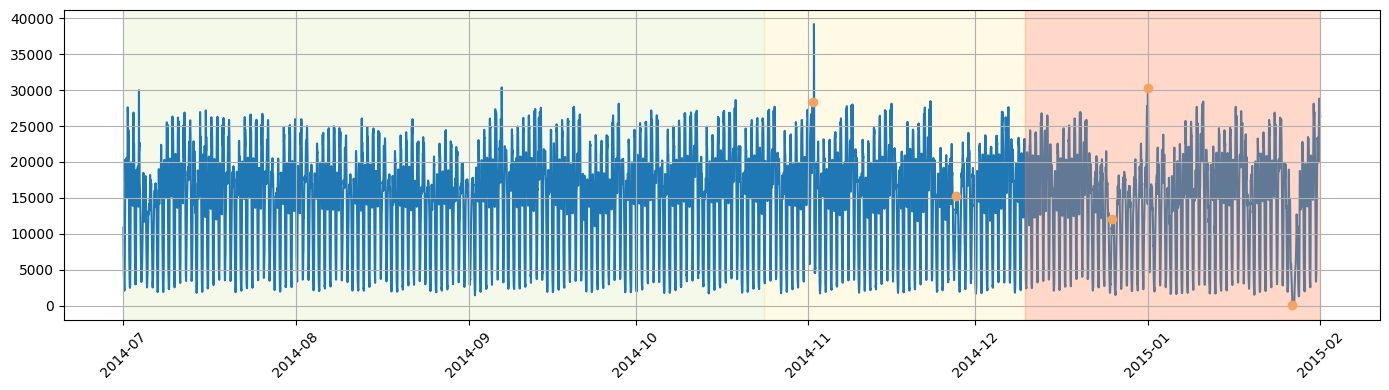

In [23]:
util.plot_series(data, labels, val_start=train_end, test_start=val_end, figsize=figsize)

* In time series, the data distribution often _drifts over time_
* When this happens, it is usually good to split the series in contiguous chunks
* I.e. the training, validation, and test set should be sequences

## Optimize the Threshold

**Let's see the results of threshold optimization**

In [25]:
best_thr, best_cost = util.opt_thr(signal_opt, labels_opt, windows_opt,  cmodel, thr_range)
print(f'Best threshold: {best_thr:.3f}, corresponding cost: {best_cost:.3f}')

Best threshold: 15.079, corresponding cost: 15.000


* The reported cost is on the training and validation set

**For all the data (yes, we are cheating a bit) we have:**

In [26]:
ctst = cmodel.cost(signal, labels, windows, best_thr)
print(f'Cost on the whole dataset {ctst}')

Cost on the whole dataset 45


* This is, as expected, _suboptimal_
* ...But it works! We have our _first complete anomaly detection approach_